In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import random
from math import ceil

import numpy as np
import numpy.core.defchararray as np_string
import pandas as pd

import glob

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


Using TensorFlow backend.


In [2]:
work_dir = os.getcwd() 
train_dir = work_dir + '/train/'
test_dir = work_dir + '/test/'
model_path = work_dir + '/model/'

In [3]:
list_paths = glob.glob(train_dir + '*')
list_names = [i.replace(train_dir,'') for i in list_paths]
print(list_names)
name2ind = dict(zip(list_names, range(len(list_names))))
ind2name = dict(zip(range(len(list_names)),list_names))

['Sugar beet', 'Common Chickweed', 'Cleavers', 'Shepherds Purse', 'Charlock', 'Common wheat', 'Small-flowered Cranesbill', 'Loose Silky-bent', 'Scentless Mayweed', 'Fat Hen', 'Maize', 'Black-grass']


In [90]:
train_set = list()
train_label = list()
test_set = list()
test_label = list()

for i in list_names:
    glob_per_dir = glob.glob(train_dir + i + '/*')
    n_plants = len(glob_per_dir)
    n_train = int(np.round(0.8*n_plants))
    train_path_per_glob = random.sample(glob_per_dir, n_train)
    test_path_per_glob = list(set(glob_per_dir) - set(train_path_per_glob))
    train_set.extend(train_path_per_glob)
    test_set.extend(test_path_per_glob)
    train_label.extend([i]*n_train)
    test_label.extend([i]*(len(glob_per_dir) - n_train))

train_label_list = [name2ind[i] for i in train_label]
test_label_list = [name2ind[i] for i in test_label]



In [82]:
from skimage.transform import resize as imresize
import imageio

def img_reshape(img):
    img = imresize(img, (48, 48, 3))
    return img

def img_get(path):
    img = imageio.imread(path)
    img = img_reshape(img)
    return img

train_img = [img_get(i) for i in train_set]
test_img = [img_get(i) for i in test_set]

In [94]:

from keras.utils import to_categorical
train_img = np.array(train_img)
test_img = np.array(test_img)
train_label = to_categorical(np.array(train_label_list))
test_label = to_categorical(np.array(test_label_list))

In [112]:
# # model_final.summary()
from keras import backend as K
K.clear_session()
# del train_model
# del model_final

In [113]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 48,48
pretrained_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


In [101]:
# def balance_image_gen(list_names, train_dict, train_directory, BATCH_SIZE):
#     small_n = int(ceil(BATCH_SIZE / len(list_names))) # random round up
#     classes = [i for i in list_names for _ in range(small_n)]
#     list_dir = map(lambda x: [random.choice(train_dict[x]) for _ in range(small_n)], list_names)
#     list_dir = [item for sublist in list_dir for item in sublist]
#     gen_df = pd.DataFrame({'filename':list_dir, 'class':classes})
    
#     gen = ImageDataGenerator(
#         rotation_range=360.,
#         width_shift_range=0.3,
#         height_shift_range=0.3,
#         zoom_range=0.3,
#         horizontal_flip=True,
#         vertical_flip=True
#         )

#     return gen.flow_from_dataframe(gen_df, train_directory, x_col='filename', y_col='class', has_ext=True, target_size=(51, 51), batch_size = BATCH_SIZE)

In [115]:
from keras.layers import Activation

for layer in pretrained_model.layers[:5]:
    layer.trainable = False
for layer in pretrained_model.layers[5:]:
    layer.trainable = True
    
    
x = pretrained_model.output
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dense(12)(x)
predictions = Activation(activation='softmax')(x)

# creating the final model 
model_final = Model(inputs = pretrained_model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True), metrics=["accuracy"])
    

In [133]:
class_weights = dict(zip(range(len(list_names)), [1]*len(list_names)))
class_weights[7] = 2
class_weights[11] = .1

In [134]:
BATCH_SIZE = 16
EPOCHS = 200
RANDOM_STATE = 11

def get_callbacks(filepath, patience=5):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, min_delta=1e-5, patience=patience, verbose=1)
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, lr_reduce, msave]

model_name = 'vgg19'
callbacks = get_callbacks(filepath = model_path + model_name + '.hdf5', patience = 10)

gen = ImageDataGenerator(
            rotation_range=360.,
            width_shift_range=0.3,
            height_shift_range=0.3,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True
            )


model_final.fit_generator(gen.flow(train_img, train_label, batch_size = BATCH_SIZE),
                   steps_per_epoch=5*len(train_img)/BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=1,
                   shuffle=True,
                   validation_data=gen.flow(test_img, test_label, batch_size = BATCH_SIZE),
                   validation_steps=len(test_img) / BATCH_SIZE,
                   callbacks=callbacks,
                   class_weight=class_weights)

Epoch 1/200
1188/1187 [==============================] - 23s 19ms/step - loss: 0.2510 - acc: 0.8893 - val_loss: 0.2830 - val_acc: 0.8851
Epoch 2/200
1188/1187 [==============================] - 23s 19ms/step - loss: 0.2409 - acc: 0.8865 - val_loss: 0.2674 - val_acc: 0.8988
Epoch 3/200
1188/1187 [==============================] - 23s 19ms/step - loss: 0.2363 - acc: 0.8890 - val_loss: 0.2841 - val_acc: 0.8957
Epoch 4/200
1188/1187 [==============================] - 23s 19ms/step - loss: 0.2313 - acc: 0.8871 - val_loss: 0.3028 - val_acc: 0.8841
Epoch 5/200
1188/1187 [==============================] - 23s 19ms/step - loss: 0.2301 - acc: 0.8920 - val_loss: 0.2736 - val_acc: 0.8988
Epoch 6/200
1188/1187 [==============================] - 23s 19ms/step - loss: 0.2222 - acc: 0.8936 - val_loss: 0.2591 - val_acc: 0.9041
Epoch 7/200
1188/1187 [==============================] - 23s 19ms/step - loss: 0.2275 - acc: 0.8892 - val_loss: 0.2735 - val_acc: 0.8967
Epoch 8/200
1188/1187 [==================

In [ ]:
# from keras.utils import to_categorical
# train_img = np.array(train_img)
# test_img = np.array(test_img)
# train_label = to_categorical(np.array(train_label))
# test_label = to_categorical(np.array(test_label))

# train_model(train_img, train_label, test_img, test_label, model_path, model_final, list_names, train_dict, train_dir, BATCH_SIZE, model_name = 'vgg19')

In [126]:
prob = model_final.predict(test_img, verbose=1)
pred = prob.argmax(axis=-1)


949/949 [==============================] - 0s 257us/step


In [33]:
np.array(test_label_list).shape

(949,)

In [131]:
from sklearn.metrics import confusion_matrix
best_confmat = confusion_matrix(np.array(test_label_list), pred)
total_bins = best_confmat.shape[0]

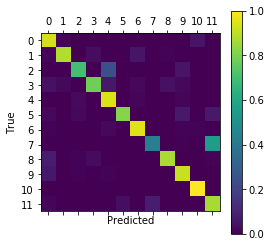

{0: 'Sugar beet', 1: 'Common Chickweed', 2: 'Cleavers', 3: 'Shepherds Purse', 4: 'Charlock', 5: 'Common wheat', 6: 'Small-flowered Cranesbill', 7: 'Loose Silky-bent', 8: 'Scentless Mayweed', 9: 'Fat Hen', 10: 'Maize', 11: 'Black-grass'}


In [132]:
### Printing heat map of confusion matrix (PHMCM) ###
# assume the confusion matrix is stored under "best_confmat"
# also required is total number of bins (here is labeled "total_bins")

import numpy as np
import matplotlib.pyplot as plt
sum_rows = np.sum(best_confmat,axis=1) # this line is summing up the total ground-truth values that were accounted for. 
nonzero_axis = [i for i in range(len(sum_rows)) if sum_rows[i] !=0] # in case some classes were never predicted (maybe very sparse), then this 
                                                                    # makes it not so ugly
scaled_confmat = best_confmat[nonzero_axis] / sum_rows[nonzero_axis,None] # if the distribution of classes were skewed, then the heatmap would 
                                                                          # be a bit awkward (bigger classes would get most of the color weight)

plt.matshow(scaled_confmat)
plt.colorbar()
tick_marks = np.arange(total_bins)
plt.xticks(tick_marks, range(total_bins))
plt.yticks(tick_marks,nonzero_axis)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(ind2name)


In [ ]:
## test set

def test_model(model_name = 'model_weight_SGD'):
    test_imgs = glob.glob(test_dir + '/*')
    
    test_set = np.array([img_get(i) for i in test_imgs])
    test_names = [i.replace(test_dir,'') for i in test_imgs]
    
    model_ = model_final
    model_.load_weights(filepath = model_path + model_name + '.hdf5')
    prob = model_.predict(test_set, verbose=1)
    pred = prob.argmax(axis=-1)
    sub = pd.DataFrame({"file": test_names,
                         "species": [ind2name[p] for p in pred]})
    #sub.to_csv("sub.csv", index=False, header=True)
    return sub

output = test_model(model_name = model_name)



In [ ]:
output.to_csv(os.getcwd() + '/transfer_learning_ResNet50_balanced.csv', index=False,)